In [1]:
# Importing all the required Libraries 
import math
import statistics as s
import scipy.stats as scs
import pandas as pd
import numpy as np
import numpy.random as npr
import yfinance as yf
from pylab import plt
from pylab import mpl
import statsmodels.api as sm
import riskfolio.Portfolio as pf
import scipy.optimize as sco

In [2]:
#Importing the required data

# Date range
start = '2016-01-01'
end = '2020-01-01'
interval= '1d' # Change interval to weekly as ETH trades every day while normal exchanges do not

#Define Benchmark
benchmark_assets=['AAPL','SPY','GLD','MSFT']
benchmark_assets.sort()

#Define Portfolio
portfolio_assets=['AAPL','SPY','GLD','MSFT','TSLA']
portfolio_assets.sort()

#Define Market 
market_assets=['^GSPC','AAPL','SPY','GLD','MSFT', 'TSLA'] #we use this to get market variance and covariance for each security
market_assets.sort()

market='^GSPC'
extra_asset='TSLA'


#Download the Benchmark Data from Yahoo Finance
benchmark_data = yf.download(benchmark_assets, start = start, end = end, interval=interval)
benchmark_data = benchmark_data.loc[:,('Adj Close', slice(None))]
benchmark_data.columns = benchmark_assets
benchmark_nb_rows=benchmark_data.shape[0]

#Download the Portfolio Data from Yahoo Finance
portfolio_data = yf.download(portfolio_assets, start = start, end = end, interval=interval)
portfolio_data = portfolio_data.loc[:,('Adj Close', slice(None))]
portfolio_data.columns = portfolio_assets
portfolio_nb_rows=portfolio_data.shape[0]

#Download the Market Benchmark Data from Yahoo Finance
market_data = yf.download(market_assets, start = start, end = end, interval=interval)
market_data = market_data.loc[:,('Adj Close', slice(None))]
market_data.columns = market_assets
market_nb_rows=market_data.shape[0]

#portfolio_data.to_csv("portfoliodata.csv")  #writes a csv file to current location




################################################################################################################################
################################                    NOTES                    ###################################################
################################################################################################################################

#rets= data[assets].pct_change().dropna() #caculating returns using percentage change 
#rets.hist(bins=40,figsize=(10,8)) # commented out histogram

#display(portfolio_data.head(portfolio_nb_rows))
#display(benchmark_data.head(benchmark_nb_rows))



[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  6 of 6 completed


In [138]:
################################################################################################################################
################################               Define Varaibles               ##################################################
################################################################################################################################

Rf=0                                     #Risk Free Rate
simulations = 100                        #Number of simulations to run

benchmark_returns=[]                     #Benchmark Returns 
benchmark_stds=[]                        #Benchmark Volatility
benchmark_noa=len(benchmark_assets)      #Number of assets in the Benchmark
benchmark_weights_list=[]

portfolio_returns=[]                     #Portfolio Returns 
portfolio_stds=[]                        #Portfolio Volatility
portfolio_noa=len(portfolio_assets)      #Number of assets in the Portfolio
portfolio_weights_list=[]

market_returns=[]                        #Market Returns 
market_var=[]                            #Market Variance

################################################################################################################################
################################               Define Formulas               ###################################################
################################################################################################################################

#Calculating the rate of return from data

benchmark_rets=np.log(benchmark_data/benchmark_data.shift(1)) #Calculating return of the Benchmark data using log difference
portfolio_rets=np.log(portfolio_data/portfolio_data.shift(1)) #Calculating return of the Portfolio data using log difference
market_rets=np.log(market_data/market_data.shift(1)) #Calculating return of the Market data using log difference

benchmark_rets.to_csv("benchreturns.csv") #Generating Benchmark returns data from prices
portfolio_rets.to_csv("portreturns.csv")  #Generating Portfolio returns data from prices
market_rets.to_csv("marketreturns.csv")  #Generating Portfolio returns data from prices


################################################################################################################################
################################               Define Functions               ##################################################
################################################################################################################################


# general return and volatility functions ####### NOTE CHANGE FORMULA TO ACCOUNT FOR WEEKLY RETURNS FOR THE THESIS #####

#Function for Benchmark Return and Standard Deviation
def benchmark_return(weights):
    return np.sum(benchmark_rets.mean()*weights)*252  # Adjust the formula to account for weekly returns?????

def benchmark_std(weights):
    return np.sqrt(np.dot(weights.T,np.dot(benchmark_rets.cov()*252,weights))) # Adjust the formula to account for weekly returns?????

def portfolio_return(weights):
    return np.sum(portfolio_rets.mean()*weights)*252  # Adjust the formula to account for weekly returns?????

def portfolio_std(weights):
    return np.sqrt(np.dot(weights.T,np.dot(portfolio_rets.cov()*252,weights))) # Adjust the formula to account for weekly returns?????

def min_portfolio_sharpe(weights):
    return -portfolio_return(weights)/portfolio_std(weights) #function to be minimized # Negative sign as we want to maximize Sharpe Ratio

def min_benchmark_sharpe(weights):
    return -benchmark_return(weights)/benchmark_std(weights) #function to be minimized # Negative sign as we want to maximize Sharpe Ratio

def Beta(cov,var): #Computing the Beta of each observation
    return cov/var # cov(i,m)/var(m)

def p_beta(weights,beta):
    return np.sum(beta*weights) # computing the beta of a portfolio of assets

def sharpe_ratio(Rf,R,std):  # Defining the function to calculate the Sharpe Ratio
    return (R-Rf)/std

def treynor_ratio(Rf,R,B):  # Defining the function to calculate the Treynor Ratio
    return (R-Rf)/B

def jensens_alpha(Rf,Rm,R,B):  # Defining the function to calculate the Jensen's Alpha
    return R-(Rf+B*(Rm-Rf))


################################################################################################################################
################################                Monte Carlo Simulation                    ######################################
################################################################################################################################

#Using monte carlo to generate random portfolio weights
#The for iteration is the monte carlo simulaion for the weights

#Setting Return and Volatility for each Benchmark Composition

for b in range (simulations):
    benchmark_weights = np.random.random(benchmark_noa)
    benchmark_weights /= np.sum(benchmark_weights)
    benchmark_returns.append(benchmark_return(benchmark_weights))
    benchmark_stds.append(benchmark_std(benchmark_weights))
    benchmark_weights_list.append(benchmark_weights)
benchmark_returns = np.array(benchmark_returns)
benchmark_stds = np.array(benchmark_stds)
benchmark_weights_list=np.array(benchmark_weights_list)

for p in range (simulations):
    portfolio_weights = np.random.random(portfolio_noa)
    portfolio_weights /= np.sum(portfolio_weights)
    portfolio_returns.append(portfolio_return(portfolio_weights))
    portfolio_stds.append(portfolio_std(portfolio_weights))
    portfolio_weights_list.append(portfolio_weights)
portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)
portfolio_weights_list=np.array(portfolio_weights_list)

#calculating the average historical return of the market portfolio
market_returns=market_rets.mean()*252 #Note make sure to annualize properly, and location for alpha


################################################################################################################################
################################                 Various Computations                     ######################################
################################################################################################################################
#Computing the covariances, note that cov(x,x)=var(x)

benchmark_covs=benchmark_rets.cov()
portfolio_covs=portfolio_rets.cov()
market_covs=market_rets.cov()

#lets keep this manual rather than a loop for accuracy due to sorting 
#market_assets=['^GSPC','AAPL','SPY','GLD','MSFT', 'TSLA']
#market_variance=market_covs.loc['^GSPC','^GSPC']
#covariance_1=market_covs.loc['^GSPC','AAPL']
#covariance_2=market_covs.loc['^GSPC','GLD']
#covariance_3=market_covs.loc['^GSPC','MSFT']
#covariance_4=market_covs.loc['^GSPC','SPY']
#covariance_5=market_covs.loc['^GSPC','TSLA']

#AAPL       GLD      MSFT       SPY      TSLA     ^GSPC

# Market and Porfolio information
market='^GSPC'
extra_asset='TSLA'

# New Variables
market_location=market_assets.index(market)  #Identifies the location of the market reference within the list
market_covariances=[]
market_cov_list=[]

#looping to get covariances in a list in the order they are sorted, check the .head() for reference
j=0
for a in market_assets: 
    market_covariances.append(market_covs.loc[market_assets[market_location],market_assets[j]])
    print(market_assets[j]) 
    market_cov_list.append([market_assets[j],market_covs.loc[market_assets[market_location],market_assets[j]]]) #sets a 2 dimensional array asset name + covariance with market
    j=j+1

print(market_covariances)
print(market_cov_list)     

#Computing Beta of each security # Note that i=position of the market
beta_list=[]
betas=[]
k=0
for ma in market_assets: #looping to get covariances and compute beta
    betas.append(Beta(market_cov_list[k][1],market_cov_list[market_location][1])) #assigns beta values without names
    beta_list.append([market_assets[k],Beta(market_cov_list[k][1],market_cov_list[market_location][1])])#sets a 2 dimensional array asset name + beta
    k=k+1
print(beta_list)

#New Variables
portfolio_betas=[]
benchmark_betas=[]
benchmark_sr_list=[]
portfolio_sr_list=[]
benchmark_tr_list=[]
portfolio_tr_list=[]
benchmark_alpha_list=[]
portfolio_alpha_list=[]
betas_port_copy=list.copy(betas)
del betas_port_copy[market_location]

extra_asset_location=market_assets.index(extra_asset)    # Identifying the extra asset in the portfolio
betas_bench_copy=list.copy(betas_port_copy)
del betas_bench_copy[extra_asset_location]               # Removing the extra asset in the portfolio

# Calculating the Portfolio Betas
portfolio_betas = np.dot(portfolio_weights_list,betas_port_copy) # Right way to calculate Beta
portfolio_betas_df = pd.DataFrame(portfolio_betas,columns=["Portfolio Beta Values"])
print(portfolio_betas_df)

# Calculating the Benchmark Betas
benchmark_betas = np.dot(benchmark_weights_list,betas_bench_copy) # Right way to calculate Beta
benchmark_betas_df = pd.DataFrame(benchmark_betas,columns=["Benchmak Beta Values"])
print(benchmark_betas_df)

# In this section we will compute extra performance metrics and add them to the dataframe 

i=0

for s in range (simulations):
    #sharpe_ratio
    benchmark_sr=sharpe_ratio(Rf,benchmark_returns[i],benchmark_stds[i])
    benchmark_sr_list.append(benchmark_sr) # list of benchmark sharpe ratios
    portfolio_sr=sharpe_ratio(Rf,portfolio_returns[i],portfolio_stds[i])
    portfolio_sr_list.append(portfolio_sr) # list of portfolio sharpe ratios
    #treynor_ratio
    benchmark_tr=treynor_ratio(Rf,benchmark_returns[i],benchmark_betas[i])
    benchmark_tr_list.append(benchmark_tr) # list of benchmark sharpe ratios
    portfolio_tr=treynor_ratio(Rf,portfolio_returns[i],portfolio_betas[i])
    portfolio_tr_list.append(portfolio_tr)
    #Jensen's Alpha
    benchmark_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_returns[i],benchmark_betas[i])
    benchmark_alpha_list.append(benchmark_alpha) # list of benchmark sharpe ratios
    portfolio_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_returns[i],portfolio_betas[i])
    portfolio_alpha_list.append(portfolio_alpha)
    i=i+1
    
    
benchmark_sr_df = pd.DataFrame(benchmark_sr_list,columns=["benchmark_sharpe"])
portfolio_sr_df = pd.DataFrame(portfolio_sr_list,columns=["portfolio_sharpe"])

benchmark_tr_df = pd.DataFrame(benchmark_tr_list,columns=["benchmark_treynor"])
portfolio_tr_df = pd.DataFrame(portfolio_tr_list,columns=["portfolio_treynor"])

benchmark_alpha_df = pd.DataFrame(benchmark_alpha_list,columns=["benchmark_alpha"])
portfolio_alpha_df = pd.DataFrame(portfolio_alpha_list,columns=["portfolio_alpha"])


################################################################################################################################
################################                 Exporting Data as CSV                    ######################################
################################################################################################################################

#Generating csv file for Portfolio related CSV Files

portfolio_weights_list_df=pd.DataFrame(portfolio_weights_list,columns=portfolio_assets) #Trasnforming arrays to a dataframe
portfolio_returns_df = pd.DataFrame(portfolio_returns,columns=["portfolio_returns"])
portfolio_stds_df = pd.DataFrame(portfolio_stds,columns=["portfolio_stds"])

portfolio_weights_list_df.to_csv("portfolio_weights_list.csv") #Generating CSV files 
portfolio_returns_df.to_csv("portfolio_returns_df.csv")        #Generating CSV files 
portfolio_stds_df.to_csv("portfolio_stds_df.csv")              #Generating CSV files 
portfolio_betas_df.to_csv("portfolio_betas_df.csv")

#Generating csv file for Benchmark related CSV Files

benchmark_weights_list_df=pd.DataFrame(benchmark_weights_list,columns=benchmark_assets) #Trasnforming arrays to a dataframe
benchmark_returns_df = pd.DataFrame(benchmark_returns,columns=["benchmark_returns"])
benchmark_stds_df = pd.DataFrame(benchmark_stds,columns=["benchmark_stds"])

benchmark_weights_list_df.to_csv("benchmark_weights_list.csv") #Generating CSV files 
benchmark_returns_df.to_csv("benchmark_returns_df.csv")        #Generating CSV files 
benchmark_stds_df.to_csv("benchmark_stds_df.csv")              #Generating CSV files 
benchmark_betas_df.to_csv("benchmark_betas_df.csv")

#Summarizing the data into a single data frame 

benchmark_df=pd.concat([benchmark_weights_list_df,benchmark_returns_df,benchmark_stds_df,benchmark_betas_df,benchmark_sr_df,benchmark_tr_df,benchmark_alpha_df],axis=1)
benchmark_df.to_csv("benchmark_df.csv") 

portfolio_df=pd.concat([portfolio_weights_list_df,portfolio_returns_df,portfolio_stds_df,portfolio_betas_df,portfolio_sr_df,portfolio_tr_df,portfolio_alpha_df],axis=1)
portfolio_df.to_csv("portfolio_df.csv")



#display(portfolio_df.head(1000))
#display(benchmark_df.head(1000))

AAPL
GLD
MSFT
SPY
TSLA
^GSPC
[8.40667159797147e-05, -1.3237897172084432e-05, 8.845221759523512e-05, 6.59193209282367e-05, 8.684788992694005e-05, 6.599468654002254e-05]
[['AAPL', 8.40667159797147e-05], ['GLD', -1.3237897172084432e-05], ['MSFT', 8.845221759523512e-05], ['SPY', 6.59193209282367e-05], ['TSLA', 8.684788992694005e-05], ['^GSPC', 6.599468654002254e-05]]
[['AAPL', 1.2738406739568702], ['GLD', -0.2005903484980764], ['MSFT', 1.3402930180082482], ['SPY', 0.9988580048525553], ['TSLA', 1.315983065913512], ['^GSPC', 1.0]]
    Portfolio Beta Values
0                0.790143
1                1.167406
2                0.897960
3                0.990317
4                1.109613
..                    ...
95               0.949762
96               0.593702
97               0.608948
98               1.089056
99               1.073470

[100 rows x 1 columns]
    Benchmak Beta Values
0               1.084463
1               1.001530
2               0.848191
3               0.799316
4       

In [144]:

#portfolio_df.plot.scatter(x='portfolio_stds',y='portfolio_returns',marker='o',s=10,alpha=0.3,grid=True,figsize=[10,10])

In [143]:
################################################################################################################################
################################                  Performance Metrics                     ######################################
################################################################################################################################


In [328]:
#fucntion to check if allocation sums to 1
def check_sum(weights):
    return np.sum(weights)-1

#Setting the optimization conditions
benchmark_cons=({'type': 'eq','fun':check_sum}) #Constraint 
benchmark_bounds = tuple((0,1) for x in range(benchmark_noa)) #Bounderies, note that they be a squence of parameters rather than just 1
benchmark_eweights = np.array(benchmark_noa*[1./benchmark_noa,]) # setting equal weights as an initial estimation

#Optimization Command
benchmark_optimization=sco.minimize(min_benchmark_sharpe,benchmark_eweights,method='SLSQP',bounds=benchmark_bounds,constraints=benchmark_cons)  

#Results    
benchmark_opt_weights=benchmark_optimization['x'].round(3) #calculating the Optimal Portfolio weights 
benchmark_opt_return=benchmark_return(benchmark_opt_weights) #Calculating the return of the Optimal Portfolio
benchmark_opt_std=benchmark_std(benchmark_opt_weights) #Calculating the volatility of the Optimal Portfolio
benchmark_opt_beta=p_beta(benchmark_opt_weights,betas_bench_copy)#Calculating the Beta of the Optimal Portfolio
benchmark_opt_sr=sharpe_ratio(Rf,benchmark_opt_return,benchmark_opt_std) #Calculating the Sharpe Ratio of the Optimal Portfolio
benchmark_opt_tr=treynor_ratio(Rf,benchmark_opt_return,benchmark_opt_beta)#Calculating the treynor Ratio of the Optimal Portfolio
benchmark_opt_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_opt_return,benchmark_opt_beta)#Calculating the Alpha of the Optimal Portfolio

#Calculating the Minimum Variance Portfolio 

benchmark_minvar=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP',bounds=benchmark_bounds,constraints=benchmark_cons) 

#Results    
benchmark_minvar_weights=benchmark_minvar['x'].round(3) #calculating the Minimuim Variance Portfolio weights 
benchmark_minvar_return=benchmark_return(benchmark_minvar_weights) #Calculating the return of the Minimuim Variance Portfolio
benchmark_minvar_std=benchmark_std(benchmark_minvar_weights) #Calculating the volatility of the Minimuim Variance Portfolio
benchmark_minvar_beta=p_beta(benchmark_minvar_weights,betas_bench_copy)#Calculating the Beta of the Minimuim Variance Portfolio
benchmark_minvar_sr=sharpe_ratio(Rf,benchmark_minvar_return,benchmark_minvar_std) #Calculating the Sharpe Ratio of the Minimuim Variance Portfolio
benchmark_minvar_tr=treynor_ratio(Rf,benchmark_minvar_return,benchmark_minvar_beta)#Calculating the treynor Ratio of the Minimuim Variance Portfolio
benchmark_minvar_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_minvar_return,benchmark_minvar_beta)#Calculating the Alpha  the Minimuim Variance Portfolio


#Calculating the Naive Benchmark (Benchmakr with equal weights)

benchmark_naive_weights=benchmark_eweights #calculating the Naive Benchmark weights 
benchmark_naive_return=benchmark_return(benchmark_naive_weights) #Calculating the return of the Naive Benchmark
benchmark_naive_std=benchmark_std(benchmark_naive_weights) #Calculating the volatility of the Naive Benchmark
benchmark_naive_beta=p_beta(benchmark_naive_weights,betas_bench_copy)#Calculating the Beta of the Naive Benchmark
benchmark_naive_sr=sharpe_ratio(Rf,benchmark_naive_return,benchmark_naive_std) #Calculating the Sharpe Ratio of the Naive Benchmark
benchmark_naive_tr=treynor_ratio(Rf,benchmark_naive_return,benchmark_naive_beta)#Calculating the treynor Ratio of the Naive Benchmark
benchmark_naive_alpha=jensens_alpha(Rf,market_returns[market_location],benchmark_naive_return,benchmark_naive_beta)#Calculating the Alpha the Naive Benchmark

# Creating Optimal Benchmark Dataframe
benchmark_opt_dict={benchmark_assets[0]:benchmark_opt_weights[0],
    benchmark_assets[1]:benchmark_opt_weights[1],
    benchmark_assets[2]:benchmark_opt_weights[2],
    benchmark_assets[3]:benchmark_opt_weights[3],
    "Return":benchmark_opt_return,
    "Std": benchmark_opt_std,
    "Beta": benchmark_opt_beta,
    "Sharpe":benchmark_opt_sr,
    "Treynor":benchmark_opt_tr,
    "Alpha":benchmark_opt_alpha,
     }

benchmark_opt_df=pd.DataFrame(list(benchmark_opt_dict.items()))
benchmark_opt_df=benchmark_opt_df.set_index([0]).T
benchmark_opt_df.index=["Optimal Benchmark"]

# Creating Naive Benchmark Dataframe
benchmark_naive_dict={benchmark_assets[0]:benchmark_naive_weights[0],
    benchmark_assets[1]:benchmark_naive_weights[1],
    benchmark_assets[2]:benchmark_naive_weights[2],
    benchmark_assets[3]:benchmark_naive_weights[3],
    "Return":benchmark_naive_return,
    "Std": benchmark_naive_std,
    "Beta": benchmark_naive_beta,
    "Sharpe":benchmark_naive_sr,
    "Treynor":benchmark_naive_tr,
    "Alpha":benchmark_naive_alpha,
     }

benchmark_naive_df=pd.DataFrame(list(benchmark_naive_dict.items()))
benchmark_naive_df=benchmark_naive_df.set_index([0]).T
benchmark_naive_df.index=["Naive Benchmark"]

# Creating Minimuim Variance Benchmark Dataframe
benchmark_minvar_dict={benchmark_assets[0]:benchmark_minvar_weights[0],
    benchmark_assets[1]:benchmark_minvar_weights[1],
    benchmark_assets[2]:benchmark_minvar_weights[2],
    benchmark_assets[3]:benchmark_minvar_weights[3],
    "Return":benchmark_minvar_return,
    "Std": benchmark_minvar_std,
    "Beta": benchmark_minvar_beta,
    "Sharpe":benchmark_minvar_sr,
    "Treynor":benchmark_minvar_tr,
    "Alpha":benchmark_minvar_alpha,
     }

benchmark_minvar_df=pd.DataFrame(list(benchmark_minvar_dict.items()))
benchmark_minvar_df=benchmark_minvar_df.set_index([0]).T
benchmark_minvar_df.index=["Minvar Benchmark"]


benchmark_summary_df=pd.concat([benchmark_minvar_df.T,benchmark_naive_df.T,benchmark_opt_df.T],axis=1)

display(benchmark_summary_df)

benchmark_summary_df.to_csv("benchmark_summary_df.csv")

################################################################################################################################
################################                   Efficient Frontier                     ######################################
################################################################################################################################

# Plotting the Benchmark efficient Frontier 

benchmark_constraint_EF=({'type':'eq','fun': lambda x: benchmark_return(x)-target_return},{'type':'eq','fun': check_sum}) # Constraint
benchmark_bounds_EF= tuple((0,1) for x in benchmark_weights)        # Bounds

benchmark_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
benchmark_target_stds=[]                                   #Target Volatility Variable
for target_return in benchmark_target_returns:
    benchmark_res=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP', bounds=benchmark_bounds_EF, constraints=benchmark_constraint_EF)
    benchmark_target_stds.append(benchmark_res['fun'])
benchmark_target_stds=np.array(benchmark_target_stds)

# Plotting the Portfolio efficient Frontier 

portfolio_constraint_EF=({'type':'eq','fun': lambda x: portfolio_return(x)-target_return},{'type':'eq','fun': check_sum}) # Constraint
portfolio_bounds_EF= tuple((0,1) for x in portfolio_weights)        # Bounds

portfolio_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
portfolio_target_stds=[]                                   #Target Volatility Variable
for target_return in portfolio_target_returns:
    portfolio_res=sco.minimize(portfolio_std,portfolio_eweights,method='SLSQP', bounds=portfolio_bounds_EF, constraints=portfolio_constraint_EF)
    portfolio_target_stds.append(portfolio_res['fun'])
portfolio_target_stds=np.array(portfolio_target_stds)


#Plotting the efficient frontier

#plt.figure(figsize=(15,9))
#plt.scatter(benchmark_stds,benchmark_returns,c=benchmark_returns/benchmark_stds,marker='.',alpha=0.8,cmap='coolwarm')
#plt.plot(benchmark_target_stds,benchmark_target_returns,'x',lw=4.0)
#plt.plot(portfolio_std(benchmark_optimization['x']),benchmark_return(benchmark_optimization['x']),'y*',markersize=15.0)
#plt.plot(portfolio_std(benchmark_minvar['x']),benchmark_return(benchmark_minvar['x']),'r*',markersize=15.0)
#plt.xlabel('expected volatility')
#plt.ylabel('expected return')
#plt.colorbar(label='Sharpe ratio')



print(portfolio_target_stds)
# For the table instead of weights add individual securities , with the rows being the naive, optimal and minimuim variance portfolios
# The monte carlo generated portfolio would be used for regression and other statistical tests

,Minvar Benchmark,Naive Benchmark,Optimal Benchmark
0,,,
AAPL,0.000000,0.250000,0.175000
GLD,0.525000,0.250000,0.516000
MSFT,0.000000,0.250000,0.309000
SPY,0.475000,0.250000,0.000000
Return,0.108663,0.193921,0.179344
Std,0.078407,0.128747,0.107989
Beta,0.369148,0.853100,0.533568
Sharpe,1.385889,1.506221,1.660768
Treynor,0.294362,0.227314,0.336122


[0.12130093 0.12130093 0.12130093 0.12130093 0.12130093 0.12130093
 0.12130093 0.12130093 0.12130093 0.12130093 0.12130093 0.12130093
 0.11840916 0.10942925 0.10117339 0.09383289 0.08763808 0.08284636
 0.07971115 0.07843137 0.07876652 0.07941421 0.0801539  0.08096877
 0.08185654 0.0828148  0.08384035 0.08493205 0.08608542 0.08730008
 0.08857274 0.08990084 0.09128197 0.09271393 0.09419429 0.09572082
 0.0972914  0.09890394 0.10055601 0.10224623 0.10397255 0.10573322
 0.10752668 0.10940107 0.11138996 0.11348733 0.11568729 0.11798412
 0.12037218 0.12284626]


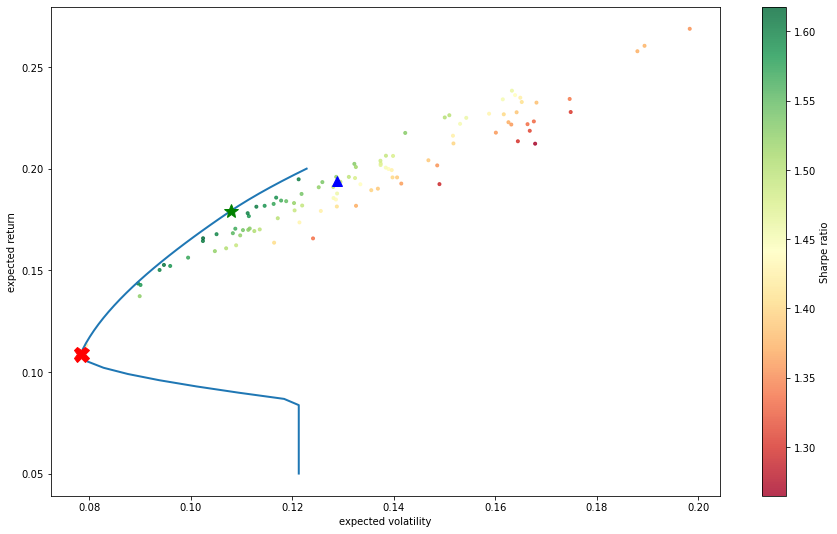

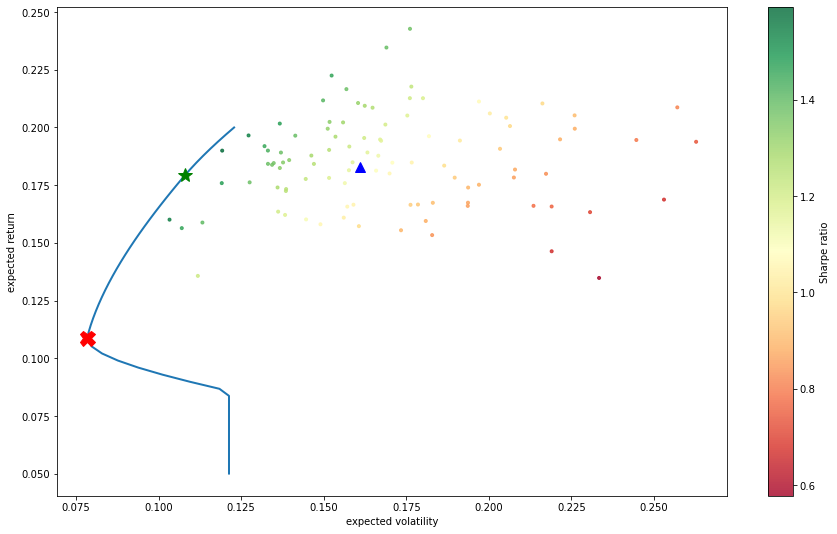

In [333]:
#colormap options PiYG PRGn BrBG PuOr RdGy RdGy RdBu RdYlBu RdYlGn Spectral coolwarm bwr seismic

#plotting the benchmark
plt.figure(figsize=(15,9))
plt.scatter(benchmark_stds,benchmark_returns,c=benchmark_returns/benchmark_stds,marker='.',alpha=0.8,cmap='RdYlGn')
plt.plot(benchmark_target_stds,benchmark_target_returns,'-',lw=2.0) #plot efficient frontier
plt.plot(benchmark_opt_std,benchmark_opt_return,'g*',markersize=15.0) #plot optimal
plt.plot(benchmark_minvar_std,benchmark_minvar_return,'rX',markersize=15.0) #plot minvar
plt.plot(benchmark_naive_std,benchmark_naive_return,'b^',markersize=10.0) #plot Naive
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
#plt.plot(x,y)  portfolio

#Plotting the portfolio
plt.figure(figsize=(15,9))
plt.scatter(portfolio_stds,portfolio_returns,c=portfolio_returns/portfolio_stds,marker='.',alpha=0.8,cmap='RdYlGn')
plt.plot(portfolio_target_stds,portfolio_target_returns,'-',lw=2.0) #plot efficient frontier
plt.plot(portfolio_opt_std,portfolio_opt_return,'g*',markersize=15.0) #plot optimal
plt.plot(portfolio_minvar_std,portfolio_minvar_return,'rX',markersize=15.0) #plot minvar
plt.plot(portfolio_naive_std,portfolio_naive_return,'b^',markersize=10.0) #plot Naive
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [290]:
#fucntion to check if allocation sums to 1
def check_sum(weights):
    return np.sum(weights)-1

#Setting the optimization conditions
portfolio_cons=({'type': 'eq','fun':check_sum}) #Constraint 
portfolio_bounds = tuple((0,1) for x in range(portfolio_noa)) #Bounderies, note that they be a squence of parameters rather than just 1
portfolio_eweights = np.array(portfolio_noa*[1./portfolio_noa,]) # setting equal weights as an initial estimation

#Optimization Command
portfolio_optimization=sco.minimize(min_portfolio_sharpe,portfolio_eweights,method='SLSQP',bounds=portfolio_bounds,constraints=portfolio_cons)  

#Results    
portfolio_opt_weights=portfolio_optimization['x'].round(3) #calculating the Optimal Portfolio weights 
portfolio_opt_return=portfolio_return(portfolio_opt_weights) #Calculating the return of the Optimal Portfolio
portfolio_opt_std=portfolio_std(portfolio_opt_weights) #Calculating the volatility of the Optimal Portfolio
portfolio_opt_beta=p_beta(portfolio_opt_weights,betas_port_copy)#Calculating the Beta of the Optimal Portfolio
portfolio_opt_sr=sharpe_ratio(Rf,portfolio_opt_return,portfolio_opt_std) #Calculating the Sharpe Ratio of the Optimal Portfolio
portfolio_opt_tr=treynor_ratio(Rf,portfolio_opt_return,portfolio_opt_beta)#Calculating the treynor Ratio of the Optimal Portfolio
portfolio_opt_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_opt_return,portfolio_opt_beta)#Calculating the Alpha of the Optimal Portfolio

#Calculating the Minimum Variance Portfolio 

portfolio_minvar=sco.minimize(portfolio_std,portfolio_eweights,method='SLSQP',bounds=portfolio_bounds,constraints=portfolio_cons) 

#Results    
portfolio_minvar_weights=portfolio_minvar['x'].round(3) #calculating the Minimuim Variance Portfolio weights 
portfolio_minvar_return=portfolio_return(portfolio_minvar_weights) #Calculating the return of the Minimuim Variance Portfolio
portfolio_minvar_std=portfolio_std(portfolio_minvar_weights) #Calculating the volatility of the Minimuim Variance Portfolio
portfolio_minvar_beta=p_beta(portfolio_minvar_weights,betas_port_copy)#Calculating the Beta of the Minimuim Variance Portfolio
portfolio_minvar_sr=sharpe_ratio(Rf,portfolio_minvar_return,portfolio_minvar_std) #Calculating the Sharpe Ratio of the Minimuim Variance Portfolio
portfolio_minvar_tr=treynor_ratio(Rf,portfolio_minvar_return,portfolio_minvar_beta)#Calculating the treynor Ratio of the Minimuim Variance Portfolio
portfolio_minvar_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_minvar_return,portfolio_minvar_beta)#Calculating the Alpha  the Minimuim Variance Portfolio


#Calculating the Naive portfolio (portfolio with equal weights)

portfolio_naive_weights=portfolio_eweights #calculating the Naive Benchmark weights 
portfolio_naive_return=portfolio_return(portfolio_naive_weights) #Calculating the return of the Naive Benchmark
portfolio_naive_std=portfolio_std(portfolio_naive_weights) #Calculating the volatility of the Naive Benchmark
portfolio_naive_beta=p_beta(portfolio_naive_weights,betas_port_copy)#Calculating the Beta of the Naive Benchmark
portfolio_naive_sr=sharpe_ratio(Rf,portfolio_naive_return,portfolio_naive_std) #Calculating the Sharpe Ratio of the Naive Benchmark
portfolio_naive_tr=treynor_ratio(Rf,portfolio_naive_return,portfolio_naive_beta)#Calculating the treynor Ratio of the Naive Benchmark
portfolio_naive_alpha=jensens_alpha(Rf,market_returns[market_location],portfolio_naive_return,portfolio_naive_beta)#Calculating the Alpha the Naive Benchmark

# Creating Optimal portfolio Dataframe
portfolio_opt_dict={
    portfolio_assets[0]:portfolio_opt_weights[0],
    portfolio_assets[1]:portfolio_opt_weights[1],
    portfolio_assets[2]:portfolio_opt_weights[2],
    portfolio_assets[3]:portfolio_opt_weights[3],
    portfolio_assets[4]:portfolio_opt_weights[4],
    "Return":portfolio_opt_return,
    "Std": portfolio_opt_std,
    "Beta": portfolio_opt_beta,
    "Sharpe":portfolio_opt_sr,
    "Treynor":portfolio_opt_tr,
    "Alpha":portfolio_opt_alpha,
     }

portfolio_opt_df=pd.DataFrame(list(portfolio_opt_dict.items()))
portfolio_opt_df=portfolio_opt_df.set_index([0]).T
portfolio_opt_df.index=["Optimal Portfolio"]

# Creating Naive portfolio Dataframe
portfolio_naive_dict={
    portfolio_assets[0]:portfolio_naive_weights[0],
    portfolio_assets[1]:portfolio_naive_weights[1],
    portfolio_assets[2]:portfolio_naive_weights[2],
    portfolio_assets[3]:portfolio_naive_weights[3],
    portfolio_assets[4]:portfolio_naive_weights[4],
    "Return":portfolio_naive_return,
    "Std": portfolio_naive_std,
    "Beta": portfolio_naive_beta,
    "Sharpe":portfolio_naive_sr,
    "Treynor":portfolio_naive_tr,
    "Alpha":portfolio_naive_alpha,
     }

portfolio_naive_df=pd.DataFrame(list(portfolio_naive_dict.items()))
portfolio_naive_df=portfolio_naive_df.set_index([0]).T
portfolio_naive_df.index=["Naive Portfolio"]

# Creating Minimuim Variance portfolio Dataframe
portfolio_minvar_dict={
    portfolio_assets[0]:portfolio_minvar_weights[0],
    portfolio_assets[1]:portfolio_minvar_weights[1],
    portfolio_assets[2]:portfolio_minvar_weights[2],
    portfolio_assets[3]:portfolio_minvar_weights[3],
    portfolio_assets[4]:portfolio_minvar_weights[4],
    "Return":portfolio_minvar_return,
    "Std": portfolio_minvar_std,
    "Beta": portfolio_minvar_beta,
    "Sharpe":portfolio_minvar_sr,
    "Treynor":portfolio_minvar_tr,
    "Alpha":portfolio_minvar_alpha,
     }

portfolio_minvar_df=pd.DataFrame(list(portfolio_minvar_dict.items()))
portfolio_minvar_df=portfolio_minvar_df.set_index([0]).T
portfolio_minvar_df.index=["Minvar Portfolio"]


portfolio_summary_df=pd.concat([portfolio_minvar_df.T,portfolio_naive_df.T,portfolio_opt_df.T],axis=1)

display(portfolio_summary_df)

portfolio_summary_df.to_csv("portfolio_summary_df.csv")



,Minvar Portfolio,Naive Portfolio,Optimal Portfolio
0,,,
AAPL,0.000000,0.200000,0.175000
GLD,0.525000,0.200000,0.516000
MSFT,0.000000,0.200000,0.309000
SPY,0.475000,0.200000,0.000000
TSLA,0.000000,0.200000,0.000000
Return,0.108663,0.182972,0.179344
Std,0.078407,0.160930,0.107989
Beta,0.369148,0.945677,0.533568
Sharpe,1.385890,1.136962,1.660768


In [150]:
################################################################################################################################
################################                   Efficient Frontier                     ######################################
################################################################################################################################

# Plotting the efficient Frontier 
target_return=0
benchmark_constraint_EF=({'type':'eq','fun': lambda x: benchmark_return(b)-target_return},{'type':'eq','fun': lambda x : np.sum(x)-1}) # Constraint
benchmark_bounds_EF= tuple((0,1) for x in benchmark_weights)        # Bounds

benchmark_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
benchmark_target_stds=[]                                   #Target Volatility Variable
for tret in benchmark_target_returns:
    benchmark_res=sco.minimize(benchmark_std,benchmark_eweights,method='SLSQP', bounds=benchmark_bounds_EF, constraints=benchmark_constraint_EF)
    benchmark_target_stds.append(benchmark_res['fun'])
benchmark_target_stds=np.array(benchmark_target_stds)


#Plotting the efficient frontier

plt.figure(figsize=(15,9))
plt.scatter(benchmark_stds,benchmark_returns,c=benchmark_returns/benchmark_stds,marker='.',alpha=0.8,cmap='coolwarm')
plt.plot(benchmark_target_stds,benchmark_target_returns,'x',lw=4.0)
plt.plot(portfolio_std(benchmark_optimization['x']),benchmark_return(benchmark_optimization['x']),'y*',markersize=15.0)
plt.plot(portfolio_std(benchmark_minvar['x']),benchmark_return(benchmark_minvar['x']),'r*',markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


KeyError: 'b'

NameError: name 'benchmark_optimization' is not defined

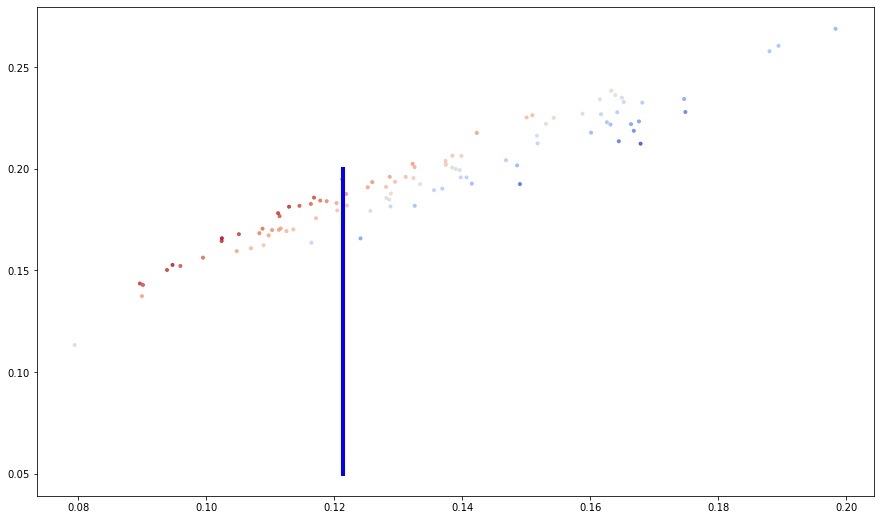

In [140]:
########################################################################################################
# Plotting the efficient Frontier 
target_return=0
benchmark_constraint_EF=({'type':'eq','fun': lambda b: benchmark_return(b)-target_return},{'type':'eq','fun': lambda b : np.sum(b)-1}) # Constraint
benchmark_bounds_EF= tuple((0,1) for b in benchmark_weights)        # Bounds

benchmark_target_returns=np.linspace(0.05,0.2,50)          #Target Returns
benchmark_target_stds=[]                                   #Target Volatility Variable
for tret in benchmark_target_returns:
    benchmark_res=sco.minimize(benchmark_std,benchmark_equal_weights,method='SLSQP', bounds=benchmark_bounds_EF, constraints=benchmark_constraint_EF)
    benchmark_target_stds.append(benchmark_res['fun'])
benchmark_target_stds=np.array(benchmark_target_stds)


#Plotting the efficient frontier

plt.figure(figsize=(15,9))
plt.scatter(benchmark_stds,benchmark_returns,c=benchmark_returns/benchmark_stds,marker='.',alpha=0.8,cmap='coolwarm')
plt.plot(benchmark_target_stds,benchmark_target_returns,'b',lw=4.0)
plt.plot(portfolio_std(benchmark_optimization['b']),benchmark_return(benchmark_optimization['b']),'y*',markersize=15.0)
plt.plot(portfolio_std(benchmark_minvar['b']),benchmark_return(benchmark_minvar['b']),'r*',markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


In [47]:
################################################################################################################################
################################                  Statistical Analysis                    ######################################
################################################################################################################################
#################    In this section we will handle the statistical analysis of the portfolios in question    ##################

#     If statistically significant, this test would show that, assuming that both returns are normally distributed 
#     and sampled independently, the process of sampling 5 years of returns and comparing them would result in one of 
#     them being superior about p% of the time, where p is the p-value. Is this what you are trying to show? 
#     Are the assumptions reasonable? If yes, then your supervisor's strategy is sound.

import researchpy as rpy
# Generate Describtive statistics for the simulated portfolios
returns_dataframe = pd.DataFrame(benchmark_returns)
returns_dataframe2 = pd.DataFrame(portfolio_returns)

#print (returns_dataframe.describe())
#print (returns_dataframe2.describe())


#rpy.ttest(returns_dataframe[0], returns_dataframe2[0])


#Performing a normality test using Shapiro-Wilk

# Shapiro-Wilk Test
from scipy.stats import shapiro
# normality test
stat, p = shapiro(returns_dataframe2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# D'Agostino and Pearson's Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(returns_dataframe2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
## https://scientificallysound.org/2017/05/16/independent-t-test-python/    
from scipy.stats import ttest_ind
from scipy.stats import t
#ttest_ind(benchmark_returns,portfolio_returns)

diff_mean=portfolio_returns.mean()-benchmark_returns.mean()

df = simulations + simulations - 2  #degrees of freedom df = N1 + N2 - 2  we will simply use simulation + simulation - 2
#MoE = t.95(df) * std_S1S2 * (1/sqrt(N))   #Formula for margin of error

t_val = t.ppf([0.975], df)  #calculate the t-value associated with our 95% cut-off using the percent point function
print(t_val)

# The next portion of the MoE formula is std_N1N2. This corresponds to the average standard deviations between groups.

from math import sqrt

benchmark_std = benchmark_returns.std()
portfolio_std = portfolio_returns.std()

std_S1S2 = sqrt(((simulations - 1)*(benchmark_std)**2 + (simulations - 1)*(portfolio_std)**2) / df) 

print(std_S1S2)

##  The final component of the MoE formula is (1/sqrt(N)). This can be computed as follows:

#sqrt(1/simulations + 1/simulations)

## now we can calculate MoE

MoE = t.ppf(0.975, df) * std_S1S2 * sqrt(1/simulations + 1/simulations)

print(MoE)

ind_t_test=ttest_ind(benchmark_returns,portfolio_returns)

print('The results of the independent t-test are: \n\tt-value = {:4.3f}\n\tp-value = {:4.3f}'.format(ind_t_test[0],ind_t_test[1]))
print ('\nThe difference between groups is {:3.1f} [{:3.1f} to {:3.1f}] (mean [95% CI])'.format(diff_mean, diff_mean - MoE, diff_mean + MoE))

Statistics=0.999, p=0.569
Sample looks Gaussian (fail to reject H0)
Statistics=0.758, p=0.685
Sample looks Gaussian (fail to reject H0)
[1.96043874]
0.025243243352168643
0.0013997272703158885
The results of the independent t-test are: 
	t-value = 8.576
	p-value = 0.000

The difference between groups is -0.0 [-0.0 to -0.0] (mean [95% CI])


In [40]:
print (benchmark_rets.describe())

              AAPL          GLD         MSFT          SPY
count  1258.000000  1258.000000  1258.000000  1258.000000
mean      0.000845     0.000183     0.001057     0.000435
std       0.015668     0.007906     0.014647     0.008470
min      -0.104924    -0.035328    -0.097099    -0.043019
25%      -0.005876    -0.004599    -0.005410    -0.002928
50%       0.000892     0.000341     0.000889     0.000502
75%       0.008871     0.004414     0.008012     0.004682
max       0.068052     0.047874     0.099413     0.049290


In [9]:
returns_dataframe = pd.DataFrame(benchmark_returns)

print (returns_dataframe.describe())

returns_dataframe2 = pd.DataFrame(portfolio_returns)

print (returns_dataframe2.describe())

                 0
count  2500.000000
mean      0.158193
std       0.027969
min       0.060230
25%       0.139968
50%       0.158646
75%       0.177098
max       0.241090
                 0
count  2500.000000
mean      0.152069
std       0.022196
min       0.078078
25%       0.136746
50%       0.152345
75%       0.166909
max       0.232601


mean=-0.032 stdv=1.001


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


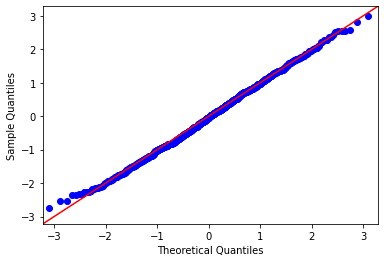

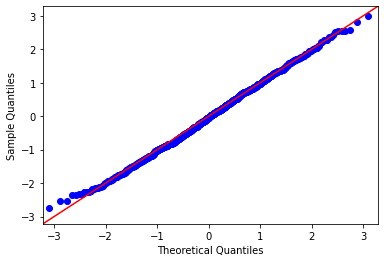

In [14]:
# generate gaussian data
import numpy as np
import scipy.stats as stats
import random
import statsmodels.api as sm
random.seed(42)

# generate univariate observations
data =  stats.norm(scale=1, loc=0).rvs(1000)

# summarize
print('mean=%.3f stdv=%.3f' % (np.mean(data), np.std(data)))

sm.qqplot(data,line='45')
